In [1]:
import lightgbm as lgb, catboost as cat

In [2]:
import pandas as pd
import joblib

In [3]:
import numpy as np
import random

In [4]:
import torch, os
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader

In [5]:
def seed_everything():
    seed = 42
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TOKENIZERS_PARALLELISM'] = 'true'
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print('-----Seed Set!-----') 

In [6]:
seed_everything()

-----Seed Set!-----


In [7]:
def read_merge_data(data_type="training"):
    #
    Dfs = []
    train_df = []
    train_output = pd.read_csv("./data_phase_one/training_output.csv", header=None)
    coords = pd.read_csv("data_phase_one/coords.csv", header=None)
    for name in ["mslp", "sst", "ssta", "t2m"]:
        df = pd.read_csv(f"./data_phase_one/{data_type}_input_{name}.csv", header=None)
        print("Shape df", df.shape)
        Dfs.append(df)
    j = 0
    for i in range(0, df.shape[0]-12, 1):
        feat = pd.concat([coords, Dfs[0].iloc[i:i+12], Dfs[1].iloc[i:i+12], Dfs[2].iloc[i:i+12], Dfs[3].iloc[i:i+12]], axis=0).reset_index(drop=True)
        tgt = train_output.iloc[i+11]
        tgt = tgt.T.reset_index(drop=True)
        feat = feat.T.reset_index(drop=True)
        feat = pd.concat([feat, tgt], axis=1)
        assert feat.shape[1]==51
        feat.columns = [f"feat_{k}" for k in range(feat.shape[1]-1)] + ["target"]
        if j < 3:
            print(feat.columns)
        train_df.append(feat)
        j += 1
    train_df = pd.concat(train_df, axis=0)
    #Dfs.index = [f"col_{i}" for i in range(848)]
    return train_df

In [8]:
#pd.read_csv("data_phase_one/coords.csv", header=None)

In [9]:
data = read_merge_data()

Shape df (849, 5774)
Shape df (849, 5774)
Shape df (849, 5774)
Shape df (849, 5774)
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49', 'target'],
      dtype='object')
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23'

In [10]:
#y = train_df["target"]

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [12]:
cv = KFold(n_splits=3, shuffle=True)

In [13]:
hidden_dims = {'linear': 896, 'input_shape': [5,10]}
class GRU(nn.Module):
    def __init__(self, dims_dict):
        super(GRU, self).__init__()
        self.name = 'GRU'
        self.dims_dict = dims_dict
        self.gru = nn.GRU(dims_dict['input_shape'][1], 128, num_layers=2, batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(dims_dict['linear'], 1024),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 128))
        self.head = nn.Linear(128, 1)
        
        self.loss = nn.MSELoss()
        
    def forward(self, x, y=None):
        shape1, shape2 = self.dims_dict['input_shape']
        x = x.reshape(x.shape[0],shape1,shape2)
        if y is None:
            out, hn = self.gru(x)
            out = out.reshape(out.shape[0],-1)
            out = torch.cat([out, hn.reshape(hn.shape[1], -1)], dim=1)
            out = self.head(self.linear(out))
            return out
        else:
            out, hn = self.gru(x)
            out = out.reshape(out.shape[0],-1)
            out = torch.cat([out, hn.reshape(hn.shape[1], -1)], dim=1)
            out = self.head(self.linear(out))
            loss = self.loss(out, y)
            return loss

class LSTM(nn.Module):
    def __init__(self, dims_dict):
        super(LSTM, self).__init__()
        self.name = 'LSTM'
        self.dims_dict = dims_dict
        self.lstm = nn.LSTM(dims_dict['input_shape'][1], 128, num_layers=2, batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(dims_dict['linear'], 1024),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 128))
        self.head = nn.Linear(128, 1)
        
        self.loss = nn.MSELoss()
        
    def forward(self, x, y=None):
        shape1, shape2 = self.dims_dict['input_shape']
        x = x.reshape(x.shape[0],shape1,shape2)
        if y is None:
            out, (hn, cn) = self.lstm(x)
            out = out.reshape(out.shape[0],-1)
            out = torch.cat([out, hn.reshape(hn.shape[1], -1)], dim=1)
            out = self.head(self.linear(out))
            return out
        else:
            out, (hn, cn) = self.lstm(x)
            out = out.reshape(out.shape[0],-1)
            out = torch.cat([out, hn.reshape(hn.shape[1], -1)], dim=1)
            out = self.head(self.linear(out))
            loss = self.loss(out, y)
            return loss

In [14]:
class Dataset:
    def __init__(self, data_x, data_y=None):
        super(Dataset, self).__init__()
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return len(self.data_x)
    
    def __getitem__(self, idx):
        if self.data_y is not None:
            return self.data_x[idx], self.data_y[idx]
        else:
            return self.data_x[idx]

In [15]:
def train_step(dataloader, model, opt, clip_norm):
    model.train()
    train_losses = []
    for x, target in dataloader:
        if torch.cuda.is_available():
            model.cuda()
            x = x.cuda()
            target = target.cuda()
        loss = model(x, target)
        train_losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_norm)
        opt.step()
        train_losses.append(loss.item())
    return np.mean(train_losses)

def validation_step(dataloader, model):
    model.eval()
    val_losses = []
    for x, target in dataloader:
        if torch.cuda.is_available():
            model.cuda()
            x = x.cuda()
            target = target.cuda()
        loss = model(x,target)
        val_losses.append(loss.item())
    return np.mean(val_losses)


def train_function(model, x_train, y_train, x_val, y_val, epochs=20, clip_norm=3.0):
    lr = 0.0003
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    if torch.cuda.is_available():
        model.cuda()
    data_x_train = torch.FloatTensor(x_train)
    data_y_train = torch.FloatTensor(y_train).unsqueeze(1)
    data_x_val = torch.FloatTensor(x_val)
    data_y_val = torch.FloatTensor(y_val).unsqueeze(1)
    train_dataloader = DataLoader(Dataset(data_x_train, data_y_train), num_workers=4, batch_size=2048, shuffle=True)
    val_dataloader = DataLoader(Dataset(data_x_val, data_y_val), num_workers=4, batch_size=2048, shuffle=False)
    best_score = 1000
    best_weights = None
    early_stop = 0
    for e in range(epochs):
        loss = train_step(train_dataloader, model, opt, clip_norm)
        val_loss = validation_step(val_dataloader, model)
        early_stop += 1
        if val_loss < best_score:
            best_score = val_loss
            best_weights = model.state_dict()
            early_stop = 0
            print('BEST ----> ')
        print(f"{model.name} Epoch {e}, train_loss {round(loss,3)}, val_loss {round(val_loss, 3)}")
        if early_stop >= 40:
            print("!!! Early stopping")
            break
    print("\nLoading model best weights...")
    model.load_state_dict(best_weights)
    print("\nDone.\n")
    return model

In [16]:
def cross_validate_models(data, epochs=120, clip_norm=5.0):
    trained_models = []
    for i, (train_idx, val_idx) in enumerate(cv.split(data)):
        print(f"\nSplit {i+1}/3...")
        x_train = data.drop(columns=["target"]).iloc[train_idx].values
        x_val = data.drop(columns=["target"]).iloc[val_idx].values
        y_train = data["target"].iloc[train_idx].values
        y_val = data["target"].iloc[val_idx].values
        print(f"\nTrain: {y_train.shape}, Val: {y_val.shape})\n")
        for Model in [GRU, LSTM]:
            model = Model(hidden_dims)
            model = train_function(model, x_train, y_train, x_val, y_val, epochs=epochs, clip_norm=clip_norm)
            model.to('cpu')
            torch.save(model.state_dict(), f'./trained_models_nn/pytorch_{model.name}_fold{i}.pt')
            trained_models.append(model)
            torch.cuda.empty_cache()
    return x_val, y_val, trained_models

In [17]:
def inference_pytorch(model, dataloader):
    model.eval()
    preds = []
    for x in dataloader:
        if torch.cuda.is_available():
            model.cuda()
            x = x.cuda()
        pred = model(x).detach().cpu().numpy()
        preds.append(pred)
    model.to('cpu')
    torch.cuda.empty_cache()
    return np.concatenate(preds, axis=0)

In [18]:
def average_prediction(X_test, trained_models):
    all_preds = []
    test_dataloader = DataLoader(Dataset(torch.FloatTensor(X_test)), num_workers=4, batch_size=2048, shuffle=False)
    for i,model in enumerate(trained_models):
        current_pred = inference_pytorch(model, test_dataloader)
        all_preds.append(current_pred)
    return np.stack(all_preds, axis=1).mean(axis=1)

In [19]:
x_val, y_val, trained_models = cross_validate_models(data, epochs=50, clip_norm=5.0)


Split 1/3...

Train: (3221892,), Val: (1610946,))

BEST ----> 
GRU Epoch 0, train_loss 0.319, val_loss 0.319
BEST ----> 
GRU Epoch 1, train_loss 0.298, val_loss 0.301
GRU Epoch 2, train_loss 0.296, val_loss 0.308
BEST ----> 
GRU Epoch 3, train_loss 0.294, val_loss 0.297
GRU Epoch 4, train_loss 0.293, val_loss 0.411
GRU Epoch 5, train_loss 0.292, val_loss 0.303
GRU Epoch 6, train_loss 0.291, val_loss 0.304
GRU Epoch 7, train_loss 0.29, val_loss 0.319
GRU Epoch 8, train_loss 0.289, val_loss 0.33
GRU Epoch 9, train_loss 0.289, val_loss 0.316
GRU Epoch 10, train_loss 0.289, val_loss 0.302
BEST ----> 
GRU Epoch 11, train_loss 0.288, val_loss 0.287
GRU Epoch 12, train_loss 0.288, val_loss 0.306
GRU Epoch 13, train_loss 0.288, val_loss 0.302
GRU Epoch 14, train_loss 0.288, val_loss 0.301
GRU Epoch 15, train_loss 0.287, val_loss 0.355
GRU Epoch 16, train_loss 0.287, val_loss 0.293
GRU Epoch 17, train_loss 0.287, val_loss 0.294
BEST ----> 
GRU Epoch 18, train_loss 0.287, val_loss 0.287
GRU Epo

In [20]:
n = 200

In [21]:
pred_lstm = average_prediction(x_val[:n], [trained_models[-1]]).squeeze()
pred_gru = average_prediction(x_val[:n], [trained_models[-2]]).squeeze()

In [22]:
print("lstm error:", np.linalg.norm(y_val[:n]-pred_lstm))
print("gru error:", np.linalg.norm(y_val[:n]-pred_gru))

lgbm error: 5.372778342894784
catboost error: 10.05247137053076


In [23]:
import matplotlib.pyplot as plt

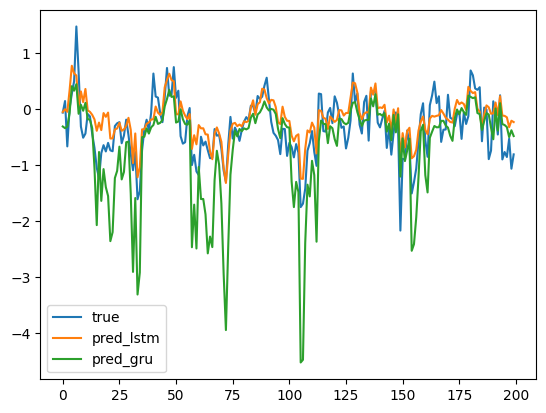

In [24]:
plt.plot(y_val[:n])
plt.plot(pred_lstm)
plt.plot(pred_gru)
plt.legend(["true", "pred_lstm", "pred_gru"])
plt.show()